In [14]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import math
import scipy as sp
from numba import cuda, jit
import numba
import threading
import time
from collections import defaultdict
import json

### Helper functions

In [15]:
def my_binary(n,p):
    bin_exp=np.zeros(p).astype(int)
    for i in range(p):
        bin_exp[i]=n % 2
        n=n//2
    return bin_exp

def all_sets(p, k):
    if k==0:
        return [[]]
    if p==1:
        return [[],[0]]
    prev = all_sets(p-1, k)
    ans = []
    ans.extend(prev)
    for x in prev:
        if len(x)<k:
            ans.append(x+[p-1])
    ans.sort(key = lambda x:(len(x),x))
    return ans

def magic_matrix(p,k):
    my_mat=np.zeros((1,p)).astype(int)
    comb_list = all_sets(p,k)
    for i in range(1,len(comb_list)):
        my_binary_vec=np.zeros(p).astype(int)
        for j in range(len(comb_list[i])):
            my_binary_vec[comb_list[i][j]]=1
        my_mat=np.concatenate((my_mat,np.array([my_binary_vec])),axis=0)
    #my_mat[0]=1
    return  my_mat

#@jit(nopython=True)
def magic_matrix_alt(p,k):
    my_mat=np.zeros((1,p)).astype(int)
    for i in range(1,2**p):
        my_binary_vec=my_binary(i,p)
        if my_binary_vec.sum() <= k :
            my_mat=np.concatenate((my_mat,np.array([my_binary_vec])),axis=0)
        def bin(x):
            return (2**p)*np.sum(x)-np.dot(x,2**np.array(range(p-1,-1,-1)))
        my_mat=my_mat[np.apply_along_axis(bin, 1, my_mat).argsort(),:]
    my_mat[0]=1
    return  my_mat

In [16]:
@jit(nopython=True)
def magic_matrix_2(X_gen):
    X_gen_2 = np.empty(shape=(len(X_gen),X_gen.shape[0], X_gen.shape[1]))
    for i in range(len(X_gen)):
        for j in range(len(X_gen)):
            if i>j :
                X_gen_2[i,j,:] = X_gen_2[j,i,:]
            else:
                X_gen_2[i,j,:] = (X_gen[i,:]+X_gen[j,:]-2*X_gen[i,:]*X_gen[j,:])*2
    return X_gen_2

@jit(nopython=True)
def sigma_matrix_alt(dosage_vec,XTX_n,X_gen_2):

    sigma_mat = np.zeros(XTX_n.shape)
    for i in range(len(X_gen)):
        for j in range(len(X_gen)):
            if i>j :
                sigma_mat[i][j] = sigma_mat[j][i]
            else:
                sigma_mat[i][j] = np.prod(1-X_gen_2[i,j,:]*(1-dosage_vec))

    return -np.min(np.linalg.eigvalsh(sigma_mat+XTX_n))

def sigma_plus_matrix_alt(dosage_vec):
    return sigma_matrix_alt(dosage_vec,XTX_n_cpu,X_gen_2)

def sigma_plus_matrix(dosage_vec, XTX_n):
    return -cp.asnumpy(cp.amin(cp.linalg.eigvalsh(XTX_n+cp.apply_along_axis(lambda x: cp.prod(1-(1-cp.asarray(dosage_vec))*x), 2, X_gen_2_cuda))))



In [58]:
def multiround_optimal(num_p, num_k, num_samples,num_trials,num_rounds):
    @jit(nopython=True)
    def sigma_matrix_alt(dosage_vec,XTX_n,X_gen_2):

        sigma_mat = np.zeros(XTX_n.shape)
        for i in range(len(X_gen)):
            for j in range(len(X_gen)):
                if i>j :
                    sigma_mat[i][j] = sigma_mat[j][i]
                else:
                    sigma_mat[i][j] = np.prod(1-X_gen_2[i,j,:]*(1-dosage_vec))

        return -np.min(np.linalg.eigvalsh(sigma_mat+XTX_n))

    def sigma_plus_matrix_alt(dosage_vec):
        return sigma_matrix_alt(dosage_vec,XTX_n_cpu,X_gen_2)

    results = defaultdict(list)
    X_gen = magic_matrix(num_p,num_k)
    num_basis = len(X_gen)
    X_gen_2 = magic_matrix_2(X_gen)
    X_gen_2_cuda = cp.asarray(X_gen_2)
    X_gen_cuda=cp.asarray(X_gen)

    beta = cp.random.uniform(low = -1, high = 1, size = num_basis)
    beta = cp.reshape(beta, (num_basis,1))
    K = 1*len(beta)

    for j in range(num_trials):
        XX = cp.random.uniform(low = 0, high = 1, size = (num_p, num_samples*num_rounds))
        X = cp.random.uniform(low = 0, high = 1, size = (num_samples*num_rounds, num_basis))

        Y = cp.random.normal(loc = 0, scale = sigma, size = (num_samples*num_rounds,1))
        XTX = cp.zeros((num_basis,num_basis))

        for t in range(num_rounds):
            if t==0:
                dosage_vec_cuda = cp.asarray([.5]*num_p)
            else:
                XTX_n_cpu = cp.asnumpy(1/num_samples * XTX)
                #print("round:",t)
                dosage_vec = sp.optimize.minimize(sigma_plus_matrix_alt, x0 = [0.5]*num_p, method = 'SLSQP', bounds = [(0,1)]*num_p,options={'maxiter' : 100, 'disp' : False})
                dosage_vec_cuda = cp.asarray(dosage_vec.x)
                #print(dosage_vec_cuda)

            #print(dosage_vec_cuda)
            #print(type(dosage_vec_cuda))


            # The Real X matrix
            def r_bin(x):
                return x>dosage_vec_cuda
            XX[:,num_samples*t:num_samples*(t+1)] = cp.apply_along_axis(r_bin, 0, XX[:,num_samples*t:num_samples*(t+1)])
            X[num_samples*t:num_samples*(t+1),:]=cp.transpose(1-2*(cp.matmul(X_gen_cuda, XX[:,num_samples*t:num_samples*(t+1)]) % 2))
            XTX += cp.matmul(cp.transpose(X[num_samples*t:num_samples*(t+1),:]), X[num_samples*t:num_samples*(t+1),:])

            min_eig = cp.min(cp.linalg.eigvalsh(XTX))

            # Y vector
            Y[num_samples*t:num_samples*(t+1)] += cp.matmul(X[num_samples*t:num_samples*(t+1),:],beta)
            ols_bound = num_basis*sigma**2/min_eig
            ridge_bound = K*num_basis*num_samples*(t+1)*sigma**2/(K*min_eig**2+num_basis*num_samples*(t+1)*sigma**2)
            lambda_ridge = sigma**2*num_basis*num_samples*(t+1)/(K*min_eig)
            if np.round(min_eig.item(),10)==0:
                beta_hat = cp.asarray([0]*len(beta))
                beta_hat = cp.reshape(beta_hat, (len(X_gen),1))
            else:
                if ols_bound<ridge_bound:
                    beta_hat = cp.matmul(cp.linalg.inv(XTX),cp.matmul(cp.transpose(X[:num_samples*(t+1),:]),Y[:num_samples*(t+1)]))
                else:
                    beta_hat = cp.matmul(cp.linalg.inv(XTX+lambda_ridge*cp.identity(num_basis)),cp.matmul(cp.transpose(X[:num_samples*(t+1),:]),Y[:num_samples*(t+1)]))
            results[t].append((cp.linalg.norm(beta-beta_hat)**2).item())
            for i in range(num_p):
                results[f'dosage_{t}'].append(dosage_vec_cuda[i].item())
    return results

In [59]:
'''
results_multiround_optimal_10_2_200 = multiround_optimal(num_p=10, num_k=2, num_samples=200,num_trials=20,num_rounds=10)
with open('results_multiround_optimal_10_2_200.txt', 'w') as file:
    file.write(json.dumps(results_multiround_optimal_10_2_200))
results_multiround_optimal_15_2_200 = multiround_optimal(num_p=15, num_k=2, num_samples=200,num_trials=20,num_rounds=10)
with open('results_multiround_optimal_15_2_200.txt', 'w') as file:
    file.write(json.dumps(results_multiround_optimal_15_2_200))
results_multiround_optimal_10_3_1000 = multiround_optimal(num_p=10, num_k=3, num_samples=1000,num_trials=20,num_rounds=10)
with open('results_multiround_optimal_10_3_1000.txt', 'w') as file:
    file.write(json.dumps(results_multiround_optimal_10_3_1000))
results_multiround_optimal_15_3_1000 = multiround_optimal(num_p=15, num_k=3, num_samples=1000,num_trials=20,num_rounds=10)
with open('results_multiround_optimal_15_3_1000.txt', 'w') as file:
    file.write(json.dumps(results_multiround_optimal_15_3_1000))
'''
'''
results_multiround_optimal_5_2_5 = multiround_optimal(num_p=5, num_k=2, num_samples=5,num_trials=20,num_rounds=10)
with open('results_multiround_optimal_5_2_5.txt', 'w') as file:
    file.write(json.dumps(results_multiround_optimal_5_2_5))
print("hi")
results_multiround_optimal_5_2_10 = multiround_optimal(num_p=5, num_k=2, num_samples=10,num_trials=20,num_rounds=10)
with open('results_multiround_optimal_5_2_10.txt', 'w') as file:
    file.write(json.dumps(results_multiround_optimal_5_2_10))
results_multiround_optimal_5_2_15 = multiround_optimal(num_p=5, num_k=2, num_samples=15,num_trials=20,num_rounds=10)
with open('results_multiround_optimal_5_2_15.txt', 'w') as file:
    file.write(json.dumps(results_multiround_optimal_5_2_15))
results_multiround_optimal_5_2_20 = multiround_optimal(num_p=5, num_k=2, num_samples=20,num_trials=20,num_rounds=10)
with open('results_multiround_optimal_5_2_20.txt', 'w') as file:
    file.write(json.dumps(results_multiround_optimal_5_2_20))


results_multiround_optimal_10_2_25 = multiround_optimal(num_p=10, num_k=2, num_samples=25,num_trials=20,num_rounds=10)
with open('results_multiround_optimal_10_2_25.txt', 'w') as file:
    file.write(json.dumps(results_multiround_optimal_10_2_25))
results_multiround_optimal_10_2_50 = multiround_optimal(num_p=10, num_k=2, num_samples=50,num_trials=20,num_rounds=10)
with open('results_multiround_optimal_10_2_50.txt', 'w') as file:
    file.write(json.dumps(results_multiround_optimal_10_2_50))
results_multiround_optimal_10_2_75 = multiround_optimal(num_p=10, num_k=2, num_samples=75,num_trials=20,num_rounds=10)
with open('results_multiround_optimal_10_2_75.txt', 'w') as file:
    file.write(json.dumps(results_multiround_optimal_10_2_75))
results_multiround_optimal_10_2_100 = multiround_optimal(num_p=10, num_k=2, num_samples=100,num_trials=20,num_rounds=10)
with open('results_multiround_optimal_10_2_100.txt', 'w') as file:
    file.write(json.dumps(results_multiround_optimal_10_2_100))
results_multiround_optimal_10_2_125 = multiround_optimal(num_p=10, num_k=2, num_samples=125,num_trials=20,num_rounds=10)
with open('results_multiround_optimal_10_2_125.txt', 'w') as file:
    file.write(json.dumps(results_multiround_optimal_10_2_125))
'''
'''
results_multiround_optimal_15_2_25 = multiround_optimal(num_p=15, num_k=2, num_samples=25,num_trials=20,num_rounds=10)
with open('results_multiround_optimal_15_2_25.txt', 'w') as file:
    file.write(json.dumps(results_multiround_optimal_15_2_25))
results_multiround_optimal_15_2_50 = multiround_optimal(num_p=15, num_k=2, num_samples=50,num_trials=20,num_rounds=10)
with open('results_multiround_optimal_15_2_50.txt', 'w') as file:
    file.write(json.dumps(results_multiround_optimal_15_2_50))
results_multiround_optimal_15_2_75 = multiround_optimal(num_p=15, num_k=2, num_samples=75,num_trials=20,num_rounds=10)
with open('results_multiround_optimal_15_2_75.txt', 'w') as file:
    file.write(json.dumps(results_multiround_optimal_15_2_75))
results_multiround_optimal_15_2_100 = multiround_optimal(num_p=15, num_k=2, num_samples=100,num_trials=20,num_rounds=10)
with open('results_multiround_optimal_15_2_100.txt', 'w') as file:
    file.write(json.dumps(results_multiround_optimal_15_2_100))
results_multiround_optimal_15_2_125 = multiround_optimal(num_p=15, num_k=2, num_samples=125,num_trials=20,num_rounds=10)
with open('results_multiround_optimal_15_2_125.txt', 'w') as file:
    file.write(json.dumps(results_multiround_optimal_15_2_125))
'''

"\nresults_multiround_optimal_15_2_25 = multiround_optimal(num_p=15, num_k=2, num_samples=25,num_trials=20,num_rounds=10)\nwith open('results_multiround_optimal_15_2_25.txt', 'w') as file:\n    file.write(json.dumps(results_multiround_optimal_15_2_25))\nresults_multiround_optimal_15_2_50 = multiround_optimal(num_p=15, num_k=2, num_samples=50,num_trials=20,num_rounds=10)\nwith open('results_multiround_optimal_15_2_50.txt', 'w') as file:\n    file.write(json.dumps(results_multiround_optimal_15_2_50))\nresults_multiround_optimal_15_2_75 = multiround_optimal(num_p=15, num_k=2, num_samples=75,num_trials=20,num_rounds=10)\nwith open('results_multiround_optimal_15_2_75.txt', 'w') as file:\n    file.write(json.dumps(results_multiround_optimal_15_2_75))\nresults_multiround_optimal_15_2_100 = multiround_optimal(num_p=15, num_k=2, num_samples=100,num_trials=20,num_rounds=10)\nwith open('results_multiround_optimal_15_2_100.txt', 'w') as file:\n    file.write(json.dumps(results_multiround_optimal_1

In [7]:
def multiround_random(num_p, num_k, num_samples,num_trials,num_rounds):

    results = defaultdict(list)
    X_gen = magic_matrix(num_p,num_k)
    num_basis = len(X_gen)
    X_gen_2 = magic_matrix_2(X_gen)
    X_gen_2_cuda = cp.asarray(X_gen_2)
    X_gen_cuda=cp.asarray(X_gen)

    beta = cp.random.uniform(low = -1, high = 1, size = num_basis)
    beta = cp.reshape(beta, (num_basis,1))
    K = 1*len(beta)

    for j in range(num_trials):
        XX = cp.random.uniform(low = 0, high = 1, size = (num_p, num_samples*num_rounds))
        X = cp.random.uniform(low = 0, high = 1, size = (num_samples*num_rounds, num_basis))

        Y = cp.random.normal(loc = 0, scale = sigma, size = (num_samples*num_rounds,1))
        XTX = cp.zeros((num_basis,num_basis))

        for t in range(num_rounds):
            dosage_vec_cuda = cp.random.uniform(low = 0, high = 1, size = num_p)
                #print(dosage_vec_cuda)

            #print(dosage_vec_cuda)
            #print(type(dosage_vec_cuda))


            # The Real X matrix
            def r_bin(x):
                return x>dosage_vec_cuda
            XX[:,num_samples*t:num_samples*(t+1)] = cp.apply_along_axis(r_bin, 0, XX[:,num_samples*t:num_samples*(t+1)])
            X[num_samples*t:num_samples*(t+1),:]=cp.transpose(1-2*(cp.matmul(X_gen_cuda, XX[:,num_samples*t:num_samples*(t+1)]) % 2))
            XTX += cp.matmul(cp.transpose(X[num_samples*t:num_samples*(t+1),:]), X[num_samples*t:num_samples*(t+1),:])

            min_eig = cp.min(cp.linalg.eigvalsh(XTX))

            # Y vector
            Y[num_samples*t:num_samples*(t+1)] += cp.matmul(X[num_samples*t:num_samples*(t+1),:],beta)
            ols_bound = num_basis*sigma**2/min_eig
            ridge_bound = K*num_basis*num_samples*(t+1)*sigma**2/(K*min_eig**2+num_basis*num_samples*(t+1)*sigma**2)
            lambda_ridge = sigma**2*num_basis*num_samples*(t+1)/(K*min_eig)
            if np.round(min_eig.item(),10)==0:
                beta_hat = cp.asarray([0]*len(beta))
                beta_hat = cp.reshape(beta_hat, (len(X_gen),1))
            else:
                if ols_bound<ridge_bound:
                    beta_hat = cp.matmul(cp.linalg.inv(XTX),cp.matmul(cp.transpose(X[:num_samples*(t+1),:]),Y[:num_samples*(t+1)]))
                else:
                    beta_hat = cp.matmul(cp.linalg.inv(XTX+lambda_ridge*cp.identity(num_basis)),cp.matmul(cp.transpose(X[:num_samples*(t+1),:]),Y[:num_samples*(t+1)]))
            results[t].append((cp.linalg.norm(beta-beta_hat)**2).item())
            for i in range(num_p):
                results[f'dosage_{t}'].append(dosage_vec_cuda[i].item())
    return results

In [12]:
'''
results_multiround_random_10_2_200 = multiround_random(num_p=10, num_k=2, num_samples=200,num_trials=20,num_rounds=10)
with open('results_multiround_random_10_2_200.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_10_2_200))
results_multiround_random_15_2_200 = multiround_random(num_p=15, num_k=2, num_samples=200,num_trials=20,num_rounds=10)
with open('results_multiround_random_15_2_200.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_15_2_200))
results_multiround_random_10_3_1000 = multiround_random(num_p=10, num_k=3, num_samples=1000,num_trials=20,num_rounds=10)
with open('results_multiround_random_10_3_1000.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_10_3_1000))
results_multiround_random_15_3_1000 = multiround_random(num_p=15, num_k=3, num_samples=1000,num_trials=20,num_rounds=10)
with open('results_multiround_random_15_3_1000.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_15_3_1000))
'''
'''
results_multiround_random_5_2_5 = multiround_random(num_p=5, num_k=2, num_samples=5,num_trials=20,num_rounds=10)
with open('results_multiround_random_5_2_5.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_5_2_5))
print("hi")
results_multiround_random_5_2_10 = multiround_random(num_p=5, num_k=2, num_samples=10,num_trials=20,num_rounds=10)
with open('results_multiround_random_5_2_10.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_5_2_10))
results_multiround_random_5_2_15 = multiround_random(num_p=5, num_k=2, num_samples=15,num_trials=20,num_rounds=10)
with open('results_multiround_random_5_2_15.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_5_2_15))
results_multiround_random_5_2_20 = multiround_random(num_p=5, num_k=2, num_samples=20,num_trials=20,num_rounds=10)
with open('results_multiround_random_5_2_20.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_5_2_20))


results_multiround_random_10_2_25 = multiround_random(num_p=10, num_k=2, num_samples=25,num_trials=20,num_rounds=10)
with open('results_multiround_random_10_2_25.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_10_2_25))
results_multiround_random_10_2_50 = multiround_random(num_p=10, num_k=2, num_samples=50,num_trials=20,num_rounds=10)
with open('results_multiround_random_10_2_50.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_10_2_50))
results_multiround_random_10_2_75 = multiround_random(num_p=10, num_k=2, num_samples=75,num_trials=20,num_rounds=10)
with open('results_multiround_random_10_2_75.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_10_2_75))
results_multiround_random_10_2_100 = multiround_random(num_p=10, num_k=2, num_samples=100,num_trials=20,num_rounds=10)
with open('results_multiround_random_10_2_100.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_10_2_100))
results_multiround_random_10_2_125 = multiround_random(num_p=10, num_k=2, num_samples=125,num_trials=20,num_rounds=10)
with open('results_multiround_random_10_2_125.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_10_2_125))
''''''
results_multiround_random_15_2_25 = multiround_random(num_p=15, num_k=2, num_samples=25,num_trials=20,num_rounds=10)
with open('results_multiround_random_15_2_25.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_15_2_25))
results_multiround_random_15_2_50 = multiround_random(num_p=15, num_k=2, num_samples=50,num_trials=20,num_rounds=10)
with open('results_multiround_random_15_2_50.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_15_2_50))
results_multiround_random_15_2_75 = multiround_random(num_p=15, num_k=2, num_samples=75,num_trials=20,num_rounds=10)
with open('results_multiround_random_15_2_75.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_15_2_75))
results_multiround_random_15_2_100 = multiround_random(num_p=15, num_k=2, num_samples=100,num_trials=20,num_rounds=10)
with open('results_multiround_random_15_2_100.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_15_2_100))
results_multiround_random_15_2_125 = multiround_random(num_p=15, num_k=2, num_samples=125,num_trials=20,num_rounds=10)
with open('results_multiround_random_15_2_125.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_15_2_125))

'''
results_multiround_random_20_2_25 = multiround_random(num_p=20, num_k=2, num_samples=25,num_trials=20,num_rounds=10)
with open('results_multiround_random_20_2_25.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_20_2_25))
results_multiround_random_20_2_50 = multiround_random(num_p=20, num_k=2, num_samples=50,num_trials=20,num_rounds=10)
with open('results_multiround_random_20_2_50.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_20_2_50))
results_multiround_random_20_2_75 = multiround_random(num_p=20, num_k=2, num_samples=75,num_trials=20,num_rounds=10)
with open('results_multiround_random_20_2_75.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_20_2_75))
results_multiround_random_20_2_100 = multiround_random(num_p=20, num_k=2, num_samples=100,num_trials=20,num_rounds=10)
with open('results_multiround_random_20_2_100.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_20_2_100))
results_multiround_random_20_2_125 = multiround_random(num_p=20, num_k=2, num_samples=125,num_trials=20,num_rounds=10)
with open('results_multiround_random_20_2_125.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_20_2_125))
results_multiround_random_20_2_200 = multiround_random(num_p=20, num_k=2, num_samples=200,num_trials=20,num_rounds=10)
with open('results_multiround_random_20_2_200.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_20_2_200))
results_multiround_random_30_2_100 = multiround_random(num_p=30, num_k=2, num_samples=100,num_trials=20,num_rounds=10)
with open('results_multiround_random_30_2_100.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_30_2_100))
results_multiround_random_30_2_200 = multiround_random(num_p=30, num_k=2, num_samples=200,num_trials=20,num_rounds=10)
with open('results_multiround_random_30_2_200.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_30_2_200))
results_multiround_random_30_2_300 = multiround_random(num_p=30, num_k=2, num_samples=300,num_trials=20,num_rounds=10)
with open('results_multiround_random_30_2_300.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_30_2_300))
results_multiround_random_30_2_400 = multiround_random(num_p=30, num_k=2, num_samples=400,num_trials=20,num_rounds=10)
with open('results_multiround_random_30_2_400.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_30_2_400))
results_multiround_random_20_2_300 = multiround_random(num_p=20, num_k=2, num_samples=300,num_trials=20,num_rounds=10)
with open('results_multiround_random_20_2_300.txt', 'w') as file:
    file.write(json.dumps(results_multiround_random_20_2_300))



In [9]:
def multiround_half(num_p, num_k, num_samples,num_trials,num_rounds):

    results = defaultdict(list)
    X_gen = magic_matrix(num_p,num_k)
    num_basis = len(X_gen)
    X_gen_2 = magic_matrix_2(X_gen)
    X_gen_2_cuda = cp.asarray(X_gen_2)
    X_gen_cuda=cp.asarray(X_gen)

    beta = cp.random.uniform(low = -1, high = 1, size = num_basis)
    beta = cp.reshape(beta, (num_basis,1))
    K = 1*len(beta)

    for j in range(num_trials):
        XX = cp.random.uniform(low = 0, high = 1, size = (num_p, num_samples*num_rounds))
        X = cp.random.uniform(low = 0, high = 1, size = (num_samples*num_rounds, num_basis))

        Y = cp.random.normal(loc = 0, scale = sigma, size = (num_samples*num_rounds,1))
        XTX = cp.zeros((num_basis,num_basis))

        for t in range(num_rounds):
            dosage_vec_cuda = cp.asarray([.5]*num_p)
                #print(dosage_vec_cuda)

            #print(dosage_vec_cuda)
            #print(type(dosage_vec_cuda))


            # The Real X matrix
            def r_bin(x):
                return x>dosage_vec_cuda
            XX[:,num_samples*t:num_samples*(t+1)] = cp.apply_along_axis(r_bin, 0, XX[:,num_samples*t:num_samples*(t+1)])
            X[num_samples*t:num_samples*(t+1),:]=cp.transpose(1-2*(cp.matmul(X_gen_cuda, XX[:,num_samples*t:num_samples*(t+1)]) % 2))
            XTX += cp.matmul(cp.transpose(X[num_samples*t:num_samples*(t+1),:]), X[num_samples*t:num_samples*(t+1),:])

            min_eig = cp.min(cp.linalg.eigvalsh(XTX))

            # Y vector
            Y[num_samples*t:num_samples*(t+1)] += cp.matmul(X[num_samples*t:num_samples*(t+1),:],beta)
            ols_bound = num_basis*sigma**2/min_eig
            ridge_bound = K*num_basis*num_samples*(t+1)*sigma**2/(K*min_eig**2+num_basis*num_samples*(t+1)*sigma**2)
            lambda_ridge = sigma**2*num_basis*num_samples*(t+1)/(K*min_eig)
            if np.round(min_eig.item(),10)==0:
                beta_hat = cp.asarray([0]*len(beta))
                beta_hat = cp.reshape(beta_hat, (len(X_gen),1))
            else:
                if ols_bound<ridge_bound:
                    beta_hat = cp.matmul(cp.linalg.inv(XTX),cp.matmul(cp.transpose(X[:num_samples*(t+1),:]),Y[:num_samples*(t+1)]))
                else:
                    beta_hat = cp.matmul(cp.linalg.inv(XTX+lambda_ridge*cp.identity(num_basis)),cp.matmul(cp.transpose(X[:num_samples*(t+1),:]),Y[:num_samples*(t+1)]))
            results[t].append((cp.linalg.norm(beta-beta_hat)**2).item())
            for i in range(num_p):
                results[f'dosage_{t}'].append(dosage_vec_cuda[i].item())

    return results

In [11]:
'''
results_multiround_half_10_2_200 = multiround_half(num_p=10, num_k=2, num_samples=200,num_trials=20,num_rounds=10)
with open('results_multiround_half_10_2_200.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_10_2_200))
results_multiround_half_15_2_200 = multiround_half(num_p=15, num_k=2, num_samples=200,num_trials=20,num_rounds=10)
with open('results_multiround_half_15_2_200.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_15_2_200))
results_multiround_half_10_3_1000 = multiround_half(num_p=10, num_k=3, num_samples=1000,num_trials=20,num_rounds=10)
with open('results_multiround_half_10_3_1000.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_10_3_1000))
results_multiround_half_15_3_1000 = multiround_half(num_p=15, num_k=3, num_samples=1000,num_trials=20,num_rounds=10)
with open('results_multiround_half_15_3_1000.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_15_3_1000))
'''
'''
results_multiround_half_5_2_5 = multiround_half(num_p=5, num_k=2, num_samples=5,num_trials=20,num_rounds=10)
with open('results_multiround_half_5_2_5.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_5_2_5))
print("hi")
results_multiround_half_5_2_10 = multiround_half(num_p=5, num_k=2, num_samples=10,num_trials=20,num_rounds=10)
with open('results_multiround_half_5_2_10.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_5_2_10))
results_multiround_half_5_2_15 = multiround_half(num_p=5, num_k=2, num_samples=15,num_trials=20,num_rounds=10)
with open('results_multiround_half_5_2_15.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_5_2_15))
results_multiround_half_5_2_20 = multiround_half(num_p=5, num_k=2, num_samples=20,num_trials=20,num_rounds=10)
with open('results_multiround_half_5_2_20.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_5_2_20))


results_multiround_half_10_2_25 = multiround_half(num_p=10, num_k=2, num_samples=25,num_trials=20,num_rounds=10)
with open('results_multiround_half_10_2_25.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_10_2_25))
results_multiround_half_10_2_50 = multiround_half(num_p=10, num_k=2, num_samples=50,num_trials=20,num_rounds=10)
with open('results_multiround_half_10_2_50.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_10_2_50))
results_multiround_half_10_2_75 = multiround_half(num_p=10, num_k=2, num_samples=75,num_trials=20,num_rounds=10)
with open('results_multiround_half_10_2_75.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_10_2_75))
results_multiround_half_10_2_100 = multiround_half(num_p=10, num_k=2, num_samples=100,num_trials=20,num_rounds=10)
with open('results_multiround_half_10_2_100.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_10_2_100))
results_multiround_half_10_2_125 = multiround_half(num_p=10, num_k=2, num_samples=125,num_trials=20,num_rounds=10)
with open('results_multiround_half_10_2_125.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_10_2_125))
'''
'''
results_multiround_half_20_2_25 = multiround_half(num_p=20, num_k=2, num_samples=25,num_trials=20,num_rounds=10)
with open('results_multiround_half_20_2_25.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_20_2_25))
results_multiround_half_20_2_50 = multiround_half(num_p=20, num_k=2, num_samples=50,num_trials=20,num_rounds=10)
with open('results_multiround_half_20_2_50.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_20_2_50))
results_multiround_half_20_2_75 = multiround_half(num_p=20, num_k=2, num_samples=75,num_trials=20,num_rounds=10)
with open('results_multiround_half_20_2_75.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_20_2_75))
results_multiround_half_20_2_100 = multiround_half(num_p=20, num_k=2, num_samples=100,num_trials=20,num_rounds=10)
with open('results_multiround_half_20_2_100.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_20_2_100))
results_multiround_half_20_2_125 = multiround_half(num_p=20, num_k=2, num_samples=125,num_trials=20,num_rounds=10)
with open('results_multiround_half_20_2_125.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_20_2_125))
results_multiround_half_20_2_200 = multiround_half(num_p=20, num_k=2, num_samples=200,num_trials=20,num_rounds=10)
with open('results_multiround_half_20_2_200.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_20_2_200))
results_multiround_half_30_2_100 = multiround_half(num_p=30, num_k=2, num_samples=100,num_trials=20,num_rounds=10)
with open('results_multiround_half_30_2_100.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_30_2_100))
results_multiround_half_30_2_200 = multiround_half(num_p=30, num_k=2, num_samples=200,num_trials=20,num_rounds=10)
with open('results_multiround_half_30_2_200.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_30_2_200))
results_multiround_half_30_2_300 = multiround_half(num_p=30, num_k=2, num_samples=300,num_trials=20,num_rounds=10)
with open('results_multiround_half_30_2_300.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_30_2_300))
results_multiround_half_30_2_400 = multiround_half(num_p=30, num_k=2, num_samples=400,num_trials=20,num_rounds=10)
with open('results_multiround_half_30_2_400.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_30_2_400))
'''
results_multiround_half_20_2_300 = multiround_half(num_p=20, num_k=2, num_samples=300,num_trials=20,num_rounds=10)
with open('results_multiround_half_20_2_300.txt', 'w') as file:
    file.write(json.dumps(results_multiround_half_20_2_300))

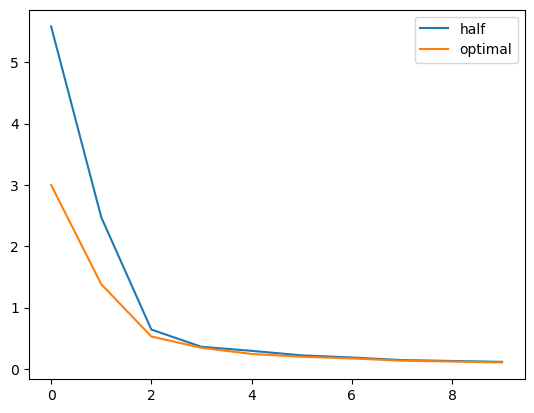

In [20]:
plt.plot(range(10), [np.mean(results_multiround_half_5_2_15[i]) for i in range(10)],label="half")
plt.plot(range(10), [np.mean(results_multiround_optimal_5_2_15[i]) for i in range(10)],label="optimal")
plt.legend()